# Introduction

There are several ways to train cuts. This is using a simulation - drawing from a probability distribution to decide if a "item" should be in or out.

This is based on the paper [_Gradient Estimation Using Stochastic Computation Graphs_](https://arxiv.org/abs/1506.05254).

## The Problem

We'll try to do this with a super simple problem - a 2D distribution that has background and signal, and then train two cuts to try to get the best S/B possible.

In [40]:
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

plt.style.use('dark_background')
_ = plt.ion()

## Data Generation

Two gaussian distributions. Build training data and truth for later training.

In [2]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Sizes of the samples. Keep same size to help
# training - as reweighing will happen anyway.
N_sig = 10000
N_back = 20000

#
data_2D_sig = np.random.multivariate_normal(
    [1.5, 2.0], [[0.5, 0.2], [0.2, 0.5]], [N_sig]
)
data_2D_back = np.random.multivariate_normal(
    [0.0, 0.0], [[9.0, 0.0], [0.0, 9.0]], [N_back]
)

data = jnp.asarray(np.concatenate([data_2D_sig, data_2D_back]))
data_truth = jnp.asarray(np.concatenate([np.ones(N_sig), np.zeros(N_back)]))

Plot the signal and background on top of each other using a kde density plot (so your eye can figure out what is going on).

<Axes: >

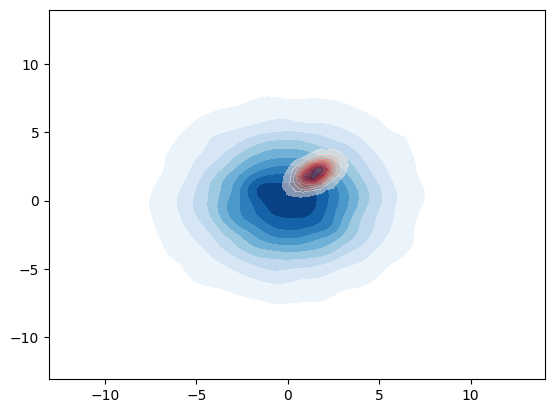

In [3]:
sns.kdeplot(x=data_2D_back[:, 0], y=data_2D_back[:, 1], cmap="Blues", fill=True)
sns.kdeplot(x=data_2D_sig[:, 0], y=data_2D_sig[:, 1], cmap="Reds", fill=True, alpha=0.5)

## $S/B$ and simple straight cuts

We first define the test statistic:

In [4]:
def f(is_sig):
    '''Return the the S/B ratio given a list of 1 or 0 for signal or background'''
    n_sig = jnp.sum(is_sig)
    n_back = len(is_sig) - n_sig
    return n_sig / n_back

And the $S/B$ for the data with no cuts...

In [5]:
print(f(data_truth))

0.5


Next, lets do this for simple straight cuts.

In [6]:
def straight_cuts (data, cuts):
    '''Return an array of 1 or 0 if the data passes the cuts
    for each cut in cuts'''
    return (data[:, 0] > cuts[0]) & (data[:, 1] > cuts[1])

A really simple grid search just to show we know what we are doing here, kind-of.

Note this next cell takes 1 minute 49 seconds on my laptop...

In [7]:
x_y_cuts = np.linspace(-10, 10, 20)
cuts = np.array(np.meshgrid(x_y_cuts, x_y_cuts)).T.reshape(-1, 2)
values = np.array([f(data_truth[straight_cuts(data, cut)]) for cut in cuts])

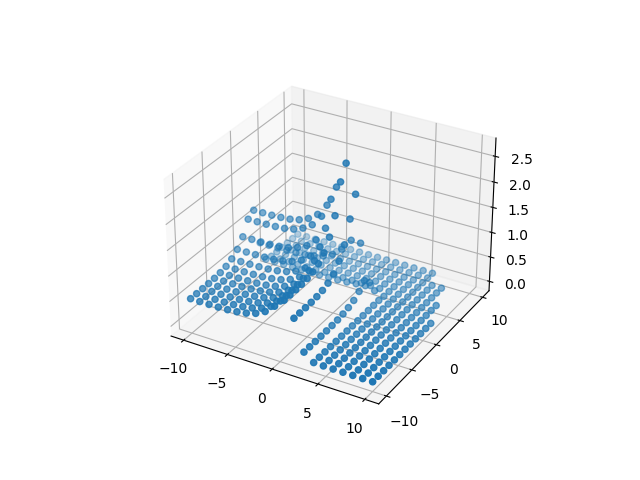

In [8]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cuts[:, 0], cuts[:, 1], values)
plt.show()

## Stochastic Cuts

Here the idea is to sample from a Bernoulli distribution for each event to see if it passes a cut. The Bernoulli distribution gives a 1 or a zero depending on the probability of getting a 1 or a 0 - so we have to have that probability. That probability will be a function of the actual cut value (which is the eventual nuisance parameter in the optimization that we are building up towards). Thinking this through:

1. We have a cut weight distribution - that we pull from our CHEP work (just a sigmoid!). For a cut value and an item value we get back a probability.
1. We use that probability to feed Bernoulli and if it is a zero the event does not pass, and a 1 it does pass.

In [9]:
def cut_sigmoid(cut: float, data, slope: float = 1.0):
    '''Return probability of passing a cut for each data point.

    Args:
        cut (float): The central cut value.
        data (jax.array): The data to be cut.
        slope (float, optional): The slope of the sigmoid (sharpness). Defaults to 1.0.

    Returns:
        jax.array: Probabilities each item has to pass the cut
    '''
    return 1 / (1 + jnp.exp(-slope * (data - cut)))

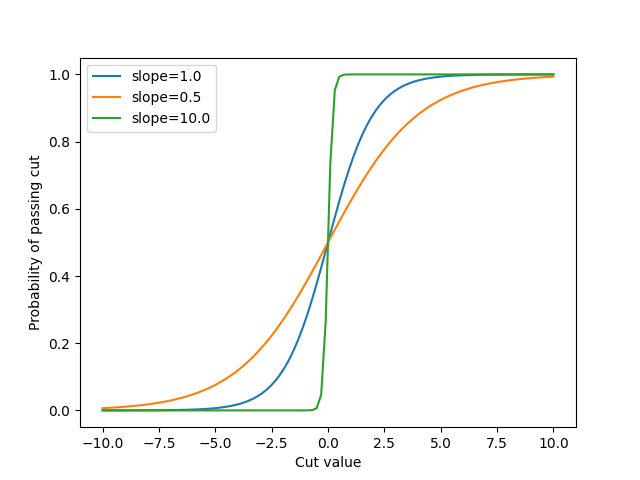

In [10]:
test_cut_values = np.linspace(-10, 10, 100)
test_cut_probs_slope_1 = cut_sigmoid(0.0, test_cut_values)
test_cut_probs_slope_01 = cut_sigmoid(0.0, test_cut_values, slope=0.5)
test_cut_probs_slope_10 = cut_sigmoid(0.0, test_cut_values, slope=10.0)

plt.figure()
plt.plot(test_cut_values, test_cut_probs_slope_1, label="slope=1.0")
plt.plot(test_cut_values, test_cut_probs_slope_01, label="slope=0.5")
plt.plot(test_cut_values, test_cut_probs_slope_10, label="slope=10.0")
plt.xlabel("Cut value")
plt.ylabel("Probability of passing cut")
plt.legend()

plt.show()

Next, given a probability distribution vs values like above, lets roll the bernoulli distribution.

In [11]:
def cut_passes(key, prob_of_passing):
    '''`prob_of_passing` has the probability of passing a cut.
    Return the result of jax.random.bernoulli to see if the cut passes or not.

    Args:
        key (PRNGKeyArray): Probability seed for JAX
        prob_of_passing (jax.Array): Array of probabilities of passing a cut
    '''
    return jax.random.bernoulli(key, p=prob_of_passing)

Do a quick test to see if this is doing what we expect.

In [12]:
test_pass_or_fail = cut_passes(jax.random.PRNGKey(0), cut_sigmoid(0.0, test_cut_values))
test_pass_or_fail

Array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True], dtype=bool)

Notice that they don't all shift, and re-runs with different random number keys also show slightly different results. So this seems solid.

## Differentiable Function

Including the loss function, we are after:

$
\sum f(x_i) \partial_\theta \log p(x_i, \theta)
$

Where:

$
f(x_i) = (1 - t_i)^2
$

and $t_i$ is if this is part of background or signal. Since $t_i$ is 1 or 0 we can ignore the square. Further, if this is signal, then $t_i = 1$, and then $f(x_i)$ is zero - so the signal contributes nothing to the loss, as expected. And,

$
p(x_i, \theta) = pass(x_i, \theta) * prob(x_i, \theta)
$

where $pass(x_i, \theta)$ is $1$ or $0$ depending on the sampling from the Bernoulli distribution, and $prob(x_i, \theta)$ is the product of the probabilities drawn from the `sigmoid` earlier in the workbook.

We can also do the opposite for those below the cut, but just signal in this case.

In [70]:
def apply_cuts(key, data, truth, cuts):
    r'''Return the gradient vs the cuts for the given data and truth.

    The gradient is calculated as:

    .. math::
        \\sum{(s_i - truth_i)^2 \\partial{prob_i}}

    Args:
        key (jax.PRNGKey): JAX PRNG key
        data (jax.Array): The data, one column per cut
        truth (jax.Array): 0 for background, 1 for truth
        cuts (jax.Array): An entry per cut, with the cut value
    '''
    # Calculate the probability of passing the cut. This is a 2D array of
    # the cut probabilities.
    prob_of_passing = cut_sigmoid(cuts, data)

    # Now draw from the bernoulli distribution to see if the cut passes or not.
    # This is a 2D array of True or False
    pass_or_fail_by_cut = cut_passes(key, prob_of_passing)
    pass_or_fail = jnp.prod(pass_or_fail_by_cut, axis=1)

    # a separate function to calculate the log grad for only things we are interested in.
    def log_prob(interesting):
        '''The log probability of passing the cuts.

        Args:
            interesting (jax.array): The probabilities of passing each cut

        Returns:
            jax.array: The log probability of each event passing the cuts
        '''
        pass_prob = jnp.prod(interesting, axis=1)
        log_prob = jnp.log(pass_prob)
        return log_prob
    
    # Return the gradient of the loss function:
    # 1. Sum log_prob of background that passes the cuts
    # 2. Sum log_prob of signal that fails the cuts
    events_passed = prob_of_passing[pass_or_fail == 1]
    events_passed_truth = truth[pass_or_fail == 1]
    events_passed_background = events_passed[events_passed_truth == 0]

    # events_failed = prob_of_passing[pass_or_fail == 0]
    # events_failed_truth = truth[pass_or_fail == 0]
    # events_failed_signal = events_failed[events_failed_truth == 1]

    return (
        log_prob(events_passed_background).sum()
        # + log_prob(events_failed_signal).sum()
    )

def cut_grad(key, data, truth, cuts):
    return jax.grad(lambda c: apply_cuts(key, data, truth, c))(cuts)

In [75]:
the_value = jnp.asarray([apply_cuts(jax.random.PRNGKey(0), data, data_truth, jnp.asarray([c, c])) for c in test_cut_values])

[0.99997365 0.9999918 ] [0.54378444 1.714662  ] [-10. -10.]


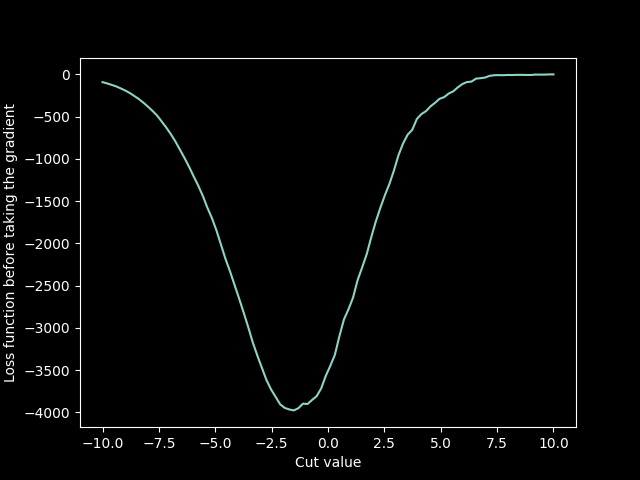

In [72]:
plt.figure()
plt.plot(test_cut_values, the_value)
plt.xlabel("Cut value")
plt.ylabel("Loss function before taking the gradient")
plt.show()

In [73]:
the_grad_value = jnp.asarray([cut_grad(jax.random.PRNGKey(0), data, data_truth, jnp.asarray([c, c])) for c in test_cut_values])

/tmp/ipykernel_8259/4166613180.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


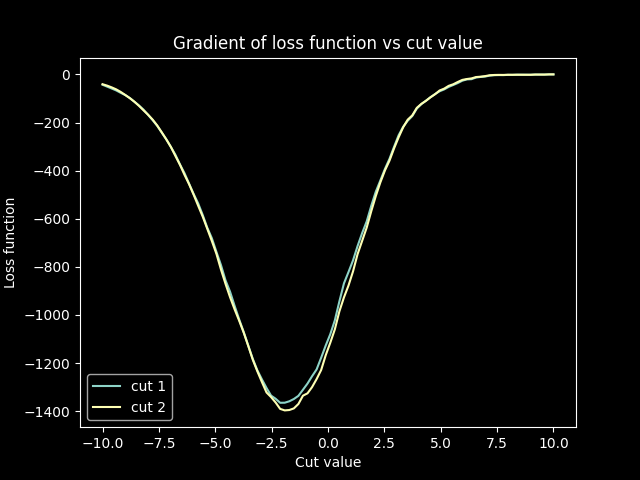

In [74]:
plt.figure()
plt.plot(test_cut_values, the_grad_value[:, 0], label="cut 1")
plt.plot(test_cut_values, the_grad_value[:, 1], label="cut 2")
plt.xlabel("Cut value")
plt.ylabel("Loss function")
plt.title("Gradient of loss function vs cut value")
plt.legend()
plt.show()

In [34]:
cut_grad(jax.random.PRNGKey(0), data, data_truth, jnp.asarray([-30.0, -10.0]))

Array([-1.529054e-07, -4.091007e+01], dtype=float32)

In [17]:
cut_sigmoid(0.0, data[:, 0])

Array([0.63269234, 0.62355447, 0.8878948 , ..., 0.99038213, 0.94589466,
       0.44456345], dtype=float32)

## 